In [11]:
#Load the usual suspects

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [61]:
# Load the data

with np.load('/Users/David/Desktop/EPFL Applied ML/cifar4-train.npz', allow_pickle=False) as npz_file:
    pixels = npz_file['pixels'].astype('float32')
    overfeat = npz_file['overfeat']
    labels = npz_file['labels']
    names = npz_file['names']
    allow = npz_file['allow_pickle']
    
print('Pixels : {:}'.format(pixels.shape),
      'Overfeat: {:}'.format(overfeat.shape),
      'Labels: {:}'.format(labels.shape),
      'Names: {:}'.format(names.shape), 
      'Allow pickle: {:}'.format(allow.shape))

Pixels : (5000, 3072) Overfeat: (5000, 4096) Labels: (5000,) Names: (4,) Allow pickle: ()


In [62]:
# Rename the data and split into train (3200), test (1000) and validation (800) sets
X_ov = overfeat
X_px = pixels
y = labels

X_ov_tr, X_ov_te, X_px_tr, X_px_te, y_tr, y_te = train_test_split(X_ov, X_px, y, test_size=1000, stratify=y, random_state=0)
X_ov_tr, X_ov_val, X_px_tr, X_px_val, y_tr, y_val = train_test_split(X_ov_tr, X_px_tr, y_tr, test_size=800, stratify=y_tr, random_state=0)

# Double check dimensions for the overfeat data:
print('Train set: {:}'.format(X_ov_tr.shape), 'Test set: {:}'.format(X_ov_te.shape), 'Validation set: {:}'.format(X_ov_val.shape))

Train set: (3200, 4096) Test set: (1000, 4096) Validation set: (800, 4096)


In [63]:
# Transform the data by scaling to improve performance of the gradient descent optimizer. Also reshape it to a 32x32 RGB image.

scaler = StandardScaler().fit(X_px_tr)
X_train_standard = scaler.transform(X_px_tr).reshape(-1, 32, 32, 3)
X_valid_standard = scaler.transform(X_px_val).reshape(-1, 32, 32, 3)
X_test_standard = scaler.transform(X_px_te).reshape(-1, 32, 32, 3)

In [64]:
# Define a function that will be used to select batches of data, using a Python generator

def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [65]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    dropout = tf.placeholder(dtype=tf.bool)
    alpha = tf.placeholder(dtype=tf.float32) # placeholder to pass as regularization term
        
    # Convolutional layer #1 with 64 filters
    conv = tf.layers.conv2d(
        X, # Input data
        filters=64, # 64 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' # Add name
    )
    
    #Get weights of the convolutional layer
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Max pooling layer #1
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )

    # Convolutional layer #2
    conv2 = tf.layers.conv2d(
        pool, # Max pooling output
        filters=64, # 16 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )

    # Max pooling layer #2
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
    
    # Flatten output using contrib.layers
    flat_output = tf.contrib.layers.flatten(pool2)

    # Hidden layer 
    hidden = tf.layers.dense(
        flat_output, 256, activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Apply dropout to hidden layer
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=dropout)

    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None,
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    l2_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W1) # L2 term which includes the hidden and output weight matrices
    loss = mean_ce + alpha * l2_term # total loss with penalization
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(loss)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [90]:
# Rerun the neural network with selected values for alpha and the learning rate

train_acc_values = [] # empty list to fill with mean training accuracy across batches
valid_acc_values = [] # empty list to fill with validation accuracy

mean_train = [] # empty list to fill with the mean training accuracy for the last 3 epochs
mean_valid = [] # empty list to fill with the mean validation accuracy for the last 3 epochs

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)
            
    for epoch in range(100):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data of size 64
        for X_batch, y_batch in get_batches(X_train_standard, y_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.0008, # Learning rate
                alpha: 0.01, # Regularization term
                dropout: True # Apply dropout for the training set
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)
        train_acc_values.append(np.mean(batch_acc))
            
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_standard,
            y: y_val,
            dropout: False # do not apply dropout because it is the validation set, and we are not fitting anything
        })
        valid_acc_values.append(valid_acc)

        # Print progress for the epochs
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))   
        
    mean_train.append(np.mean(train_acc_values[-3:])) # save mean values of the 3 last epochs
    mean_valid.append(np.mean(valid_acc_values[-3:]))     
        
    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()
    biases_hidden = b1.eval()
    biases_output = b2.eval()
    
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Test accuracy
    test_acc_val = sess.run(accuracy, feed_dict={
        X: X_test_standard, # Rescaled data
        y: y_te,
        W1: weights_hidden, # Set hidden weights
        b1: biases_hidden, # Set hidden biases
        W2: weights_output, # Set output weights
        b2: biases_output, # Set output biases
        dropout: False # do not apply dropout because it is the test set, and we are not fitting anything
    })
    print('Convolutional neural network accuracy (test set): {:.3f}'.format(test_acc_val))

Epoch 1 - valid: 0.493 train: 0.422 (mean)
Epoch 2 - valid: 0.556 train: 0.529 (mean)
Epoch 3 - valid: 0.604 train: 0.577 (mean)
Epoch 4 - valid: 0.616 train: 0.619 (mean)
Epoch 5 - valid: 0.637 train: 0.657 (mean)
Epoch 6 - valid: 0.675 train: 0.699 (mean)
Epoch 7 - valid: 0.715 train: 0.729 (mean)
Epoch 8 - valid: 0.690 train: 0.750 (mean)
Epoch 9 - valid: 0.716 train: 0.768 (mean)
Epoch 10 - valid: 0.736 train: 0.787 (mean)
Epoch 11 - valid: 0.726 train: 0.807 (mean)
Epoch 12 - valid: 0.751 train: 0.817 (mean)
Epoch 13 - valid: 0.770 train: 0.829 (mean)
Epoch 14 - valid: 0.736 train: 0.862 (mean)
Epoch 15 - valid: 0.743 train: 0.872 (mean)
Epoch 16 - valid: 0.745 train: 0.870 (mean)
Epoch 17 - valid: 0.729 train: 0.891 (mean)
Epoch 18 - valid: 0.740 train: 0.894 (mean)
Epoch 19 - valid: 0.766 train: 0.903 (mean)
Epoch 20 - valid: 0.767 train: 0.917 (mean)
Epoch 21 - valid: 0.734 train: 0.921 (mean)
Epoch 22 - valid: 0.764 train: 0.932 (mean)
Epoch 23 - valid: 0.765 train: 0.944 (mea

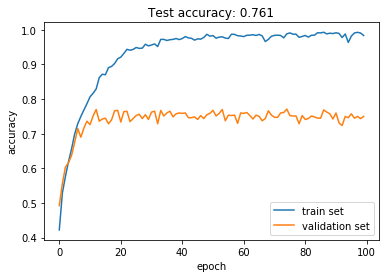

In [91]:
# Plot the results for training and validation for the tuned parameters

%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(train_acc_values, label='train set')
plt.plot(valid_acc_values, label='validation set')
plt.title('Test accuracy: {:.3f}'.format(
    test_acc_val
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

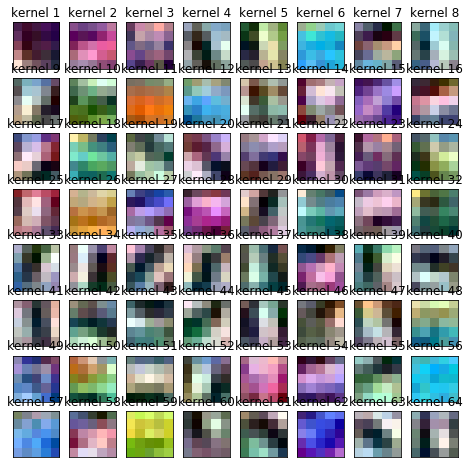

In [92]:
# As we did in the exercises, plot the trained weights of the kernels from the first convolutional layer.

# Create figure with 64 subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))

# Plot the weights of the 64 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get the ith kernel
    kernel = kernels[:, :, :, i]

    # Reshape weight values into a 5x5x3 array with values rescaled between 0 and 1
    template = MinMaxScaler(feature_range=(0, 1)).fit_transform(kernel.reshape(-1, 1)).reshape(5, 5, 3)
    
    # Plot array
    axis.imshow(template)
    axis.set_title('kernel {}'.format(i+1))
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()